<a href="https://colab.research.google.com/github/Tinashe-code/Lithium-Ion-Battery-Sate-of-Health-Estimation/blob/main/SOHestimationCapstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from  statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import os

#Import the RNN and the LSTM modules
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import csv
import os
import json
import pandas as pd

In [ ]:

dataset = "/content/drive/MyDrive/Colab Notebooks/dataset.json"
with open(dataset) as f:
    data = json.load(f)

# Use pd.json_normalize to convert the JSON to a DataFrame
df = pd.json_normalize(data)
print(df)

     battery_id  state_of_health  \
0         B0047         1.000000   
1         B0047         0.910447   
2         B0047         0.900718   
3         B0047         0.886074   
4         B0047         0.876268   
...         ...              ...   
2799      B0055         0.779251   
2800      B0055         0.743761   
2801      B0055         0.767269   
2802      B0055         0.772895   
2803      B0055         0.750636   

                                              discharge  \
0     [[4.246711253516259, 0.0002523886105860831, 6....   
1     [[4.186635709569866, -0.0016657576690297417, 5...   
2     [[4.199922751479228, -0.003475102939983319, 6....   
3     [[4.199568876812779, -0.0008961368772834502, 4...   
4     [[4.1993968014662295, 0.000422011591452891, 4....   
...                                                 ...   
2799  [[4.206432255358412, 0.0009264194621568805, 6....   
2800  [[4.203481073295822, -0.002626747335814175, 4....   
2801  [[4.20306302939134, 0.00023679

In [ ]:
# Display all rows with any NaN values
nan_rows = df[df.isna().any(axis=1)]
print(nan_rows)


     battery_id  state_of_health  \
19        B0047              NaN   
53        B0047              NaN   
65        B0047              NaN   
91        B0045              NaN   
137       B0045              NaN   
163       B0048              NaN   
197       B0048              NaN   
209       B0048              NaN   
235       B0046              NaN   
269       B0046              NaN   
281       B0046              NaN   
293       B0043              NaN   
609       B0042              NaN   
1299      B0044              NaN   
1718      B0049              NaN   
1743      B0050              NaN   
1748      B0050              NaN   
1749      B0050              NaN   
1750      B0050              NaN   
1751      B0050              NaN   
1756      B0052              NaN   
1757      B0052              NaN   
1758      B0052              NaN   
1759      B0052              NaN   
1760      B0052              NaN   
1761      B0052              NaN   
1762      B0052             

In [ ]:
#Selecting the battery to use for training. We will use B0007  and B0006 for training

# TrainBatteryDF = df[df['battery_id']=="B0007"]
# TrainBatteryDF
#Blacklist B0033, B0050, B0052, B0025,
#With reservations   - B0026, B0049, B0029, B0028
# Select rows where battery_id is either "B0007" or "B0006"
TrainBatteryDF = df[df['battery_id'].isin(["B0007","B0006","B0005","B0040","B0041",
                                           "B0042","B0043","B0044","B0045","B0046","B0047",
                                           "B0048","B0051","B0053","B0054","B0055","B0056","B0030",
                                           "B0031","B0032","B0034","B0036","B0038","B0039","B0026",
                                           "B0027","B0028","B0029","B0018"])]
TrainBatteryDF

TrainBatteryDF = TrainBatteryDF.filter(['state_of_health','discharge'], axis=1)
TrainBatteryDF

,state_of_health,discharge
0,1.000000,"[[4.246711253516259, 0.0002523886105860831, 6...."
1,0.910447,"[[4.186635709569866, -0.0016657576690297417, 5..."
2,0.900718,"[[4.199922751479228, -0.003475102939983319, 6...."
3,0.886074,"[[4.199568876812779, -0.0008961368772834502, 4..."
4,0.876268,"[[4.1993968014662295, 0.000422011591452891, 4...."
...,...,...
2799,0.779251,"[[4.206432255358412, 0.0009264194621568805, 6...."
2800,0.743761,"[[4.203481073295822, -0.002626747335814175, 4...."
2801,0.767269,"[[4.20306302939134, 0.00023679687918736207, 6...."
2802,0.772895,"[[4.197674431245264, 0.0002223099717793719, 6...."


In [ ]:
# Check if there are any NaN values in the entire DataFrame
contains_nan = TrainBatteryDF.isna().any().any()

print(f"Does TrainBatteryDF contain any NaN values? {contains_nan}")

Does TrainBatteryDF contain any NaN values? True


In [ ]:
# Display all rows with any NaN values
nan_rows = TrainBatteryDF[TrainBatteryDF.isna().any(axis=1)]
print(nan_rows)


      state_of_health                                          discharge
19                NaN  [[4.195583212031605, -0.00300528337748224, 4.8...
53                NaN  [[4.192932934065261, 0.000603436531951827, 5.3...
65                NaN  [[4.193728328919069, 0.0007510084712899575, 5....
91                NaN  [[4.1894414322262765, 0.0006807274717778113, 5...
137               NaN  [[4.1893540752465075, -0.0018274013940157159, ...
163               NaN  [[4.171642845757827, -0.00038316875333029656, ...
197               NaN  [[4.1701191621232025, -0.00024557605061535935,...
209               NaN  [[4.170160404909495, -0.0032226168003540293, 5...
235               NaN  [[4.177351418157289, -0.002198175773465614, 5....
269               NaN  [[4.1730486061960095, -0.005485894391774395, 5...
281               NaN  [[4.174508000036821, -0.001291976272313711, 5....
293               NaN  [[4.203363159265162, -0.0036158245676936795, 2...
609               NaN  [[4.182714249550464, -0.0014

In [ ]:
# Remove rows with any NaN values
TrainBatteryDF = TrainBatteryDF.dropna()
#TrainBatteryDF_clean

In [ ]:
TrainBatteryDF

,state_of_health,discharge
0,1.000000,"[[4.246711253516259, 0.0002523886105860831, 6...."
1,0.910447,"[[4.186635709569866, -0.0016657576690297417, 5..."
2,0.900718,"[[4.199922751479228, -0.003475102939983319, 6...."
3,0.886074,"[[4.199568876812779, -0.0008961368772834502, 4..."
4,0.876268,"[[4.1993968014662295, 0.000422011591452891, 4...."
...,...,...
2799,0.779251,"[[4.206432255358412, 0.0009264194621568805, 6...."
2800,0.743761,"[[4.203481073295822, -0.002626747335814175, 4...."
2801,0.767269,"[[4.20306302939134, 0.00023679687918736207, 6...."
2802,0.772895,"[[4.197674431245264, 0.0002223099717793719, 6...."


In [ ]:
max(TrainBatteryDF['discharge'].apply(len))
#max(TrainBatteryDF['state_of_health'])
#TrainBatteryDF

653

In [ ]:
TrainBatteryDF['discharge'][2140]

[[4.201968615940368,
  -0.0008565579794345959,
  25.09329713312876,
  0.0006,
  0.0,
  0.0],
 [4.200942039471311,
  -0.0011276212441780813,
  25.10437816806932,
  0.0006,
  4.217,
  9.328],
 [3.9822597453103534,
  -2.009928912960852,
  25.106192074197992,
  1.9984,
  2.936,
  19.515],
 [3.959736047580251,
  -2.01445016418111,
  25.178774888256722,
  1.9984,
  2.941,
  28.936999999999998],
 [3.9421824971315043,
  -2.015092520880159,
  25.276001803074074,
  1.9984,
  2.929,
  38.312],
 [3.92718474310638,
  -2.0152259793690845,
  25.40235429927579,
  1.9982,
  2.917,
  47.687],
 [3.914152914318117,
  -2.012312353063046,
  25.499621839085606,
  1.9984,
  2.906,
  57.046],
 [3.902691085637858,
  -2.0123983053060797,
  25.608730701096153,
  1.9982,
  2.894,
  66.35900000000001],
 [3.892498632995477,
  -2.0127937828523477,
  25.72386553372026,
  1.9982,
  2.879,
  75.75],
 [3.883186368593699,
  -2.0134559500654743,
  25.83708132592343,
  1.9982,
  2.871,
  85.10900000000001],
 [3.874756477030

In [ ]:
TrainBatteryDF.head()

,state_of_health,discharge
0,1.000000,"[[4.246711253516259, 0.0002523886105860831, 6...."
1,0.910447,"[[4.186635709569866, -0.0016657576690297417, 5..."
2,0.900718,"[[4.199922751479228, -0.003475102939983319, 6...."
3,0.886074,"[[4.199568876812779, -0.0008961368772834502, 4..."
4,0.876268,"[[4.1993968014662295, 0.000422011591452891, 4...."


In [ ]:
#Creating subset of the dataset creating only the values we need

# print(df['discharge'])

#['discharge']

#dfcopy = df[df['battery_id']=="B0055"]['discharge'],['state_of_health']

#dfcopy = df['discharge']
#dfcopy

#dfcopy = df.filter(['state_of_health','discharge'], axis=1)

In [ ]:
# def select_columns(data_frame, column_names):
#     new_frame = data_frame.loc[:, column_names]
#     return new_frame

# selected_columns = ['discharge']
# new = select_columns(df, selected_columns)

In [ ]:
#Creating a dataframe for each discharge cycle for a selected battery
#TrainBatteryDF.info()

df2 = pd.DataFrame(TrainBatteryDF['discharge'][2140],  columns=['Voltage_measured',	'Current_measured',	'Temperature_measured',	'Current_load',	'Voltage_load',	'Time'])
df2

,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time
0,4.201969,-0.000857,25.093297,0.0006,0.000,0.000
1,4.200942,-0.001128,25.104378,0.0006,4.217,9.328
2,3.982260,-2.009929,25.106192,1.9984,2.936,19.515
3,3.959736,-2.014450,25.178775,1.9984,2.941,28.937
4,3.942182,-2.015093,25.276002,1.9984,2.929,38.312
...,...,...,...,...,...,...
295,3.579262,-0.001569,34.864823,0.0006,0.000,2781.312
296,3.581964,-0.003067,34.814770,0.0006,0.000,2791.062
297,3.584484,-0.003079,34.676258,0.0006,0.000,2800.828
298,3.587336,0.001219,34.565580,0.0006,0.000,2810.640


In [ ]:
max(df['state_of_health'])

1.0

In [ ]:
#Normalizing data in the df2 dataset



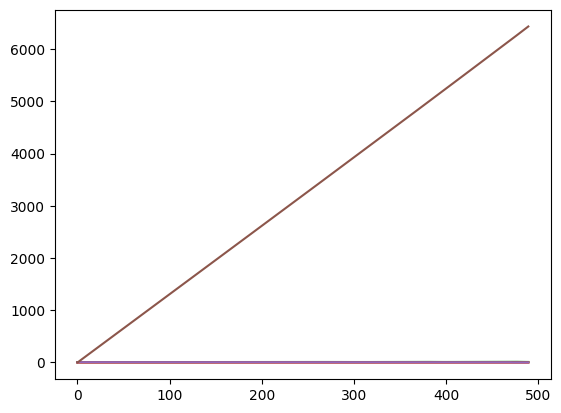

In [ ]:
plt.plot(TrainBatteryDF['discharge'].iloc[0])

In [ ]:
# @title state_of_health

from matplotlib import pyplot as plt
dfcopy['state_of_health'].plot(kind='line', figsize=(8, 4), title='state_of_health')
plt.gca().spines[['top', 'right']].set_visible(False)

NameError: name 'dfcopy' is not defined

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:

TrainBatteryDF['discharge'][2140]

[[4.201968615940368,
  -0.0008565579794345959,
  25.09329713312876,
  0.0006,
  0.0,
  0.0],
 [4.200942039471311,
  -0.0011276212441780813,
  25.10437816806932,
  0.0006,
  4.217,
  9.328],
 [3.9822597453103534,
  -2.009928912960852,
  25.106192074197992,
  1.9984,
  2.936,
  19.515],
 [3.959736047580251,
  -2.01445016418111,
  25.178774888256722,
  1.9984,
  2.941,
  28.936999999999998],
 [3.9421824971315043,
  -2.015092520880159,
  25.276001803074074,
  1.9984,
  2.929,
  38.312],
 [3.92718474310638,
  -2.0152259793690845,
  25.40235429927579,
  1.9982,
  2.917,
  47.687],
 [3.914152914318117,
  -2.012312353063046,
  25.499621839085606,
  1.9984,
  2.906,
  57.046],
 [3.902691085637858,
  -2.0123983053060797,
  25.608730701096153,
  1.9982,
  2.894,
  66.35900000000001],
 [3.892498632995477,
  -2.0127937828523477,
  25.72386553372026,
  1.9982,
  2.879,
  75.75],
 [3.883186368593699,
  -2.0134559500654743,
  25.83708132592343,
  1.9982,
  2.871,
  85.10900000000001],
 [3.874756477030

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Normalize the discharge data
def normalize_discharge(discharge):
    scaler = MinMaxScaler()
    return scaler.fit_transform(discharge).tolist()

# Apply normalization to the 'discharge' column
TrainBatteryDF['discharge'] = TrainBatteryDF['discharge'].apply(lambda x: normalize_discharge(np.array(x)))

# Calculate the mean of the 'discharge' column
discharge_means = TrainBatteryDF['discharge'].apply(np.mean)

# Define a custom padding function
def pad_with_mean(sequences, maxlen, mean_values):
    padded_sequences = []
    for seq, mean_val in zip(sequences, mean_values):
        # Calculate the number of padding elements needed
        num_padding = maxlen - len(seq)
        # Create the padding array filled with the mean value
        padding = np.full((num_padding, seq.shape[1]), mean_val, dtype='float16')
        # Concatenate the sequence and the padding
        padded_seq = np.concatenate([seq, padding], axis=0)
        padded_sequences.append(padded_seq)
    return padded_sequences

# Determine the maximum length of the sequences
max_length = max(TrainBatteryDF['discharge'].apply(len))

# Apply custom padding with mean values
TrainBatteryDF['discharge'] = pad_with_mean(TrainBatteryDF['discharge'], maxlen=max_length, mean_values=discharge_means)

# Convert the padded sequences back to a list if necessary
TrainBatteryDF['discharge'] = TrainBatteryDF['discharge'].apply(lambda x: x.tolist())

X = np.array(TrainBatteryDF['discharge'].tolist())
y = np.array(TrainBatteryDF['state_of_health'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape for LSTM input (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

TrainBatteryDF['discharge'][2140][20]

<ipython-input-15-6ff4cf03c2f9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TrainBatteryDF['discharge'] = TrainBatteryDF['discharge'].apply(lambda x: normalize_discharge(np.array(x)))
<ipython-input-15-6ff4cf03c2f9>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TrainBatteryDF['discharge'] = pad_with_mean(TrainBatteryDF['discharge'], maxlen=max_length, mean_values=discharge_means)
<ipython-input-15-6ff4cf03c2f9>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

[0.7500633742794052,
 0.001202130699908377,
 0.1283944270085291,
 0.9998998898788669,
 0.66801043395779,
 0.06673474235832633]

In [ ]:
y

array([1.        , 0.91044729, 0.90071793, ..., 0.76726885, 0.77289496,
       0.75063645])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.4))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=1e-5, clipnorm=0.01)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Summary of the model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 653, 50)           11400     
                                                                 
 dropout (Dropout)           (None, 653, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 31651 (123.64 KB)
Trainable params: 31651 (123.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=2, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Predictions
y_pred = model.predict(X_test)


# # Train the model
# history = model.fit(X_train, y_train, epochs=2, batch_size=2, validation_split=0.2)

# # Evaluate the model
# loss = model.evaluate(X_test, y_test)
# print(f'Test Loss: {loss}')

# # Predictions
# y_pred = model.predict(X_test)

NameError: name 'model' is not defined

16/16 [==============================] - 3s 160ms/step
Training Metrics:
Mean Squared Error (MSE): 0.05204347565970455
Root Mean Squared Error (RMSE): 0.22813039179316846
Mean Absolute Error (MAE): 0.1498821331953208
R-squared (R²): 0.0668376532726419
Testing Metrics:
Mean Squared Error (MSE): 0.05471596994334356
Root Mean Squared Error (RMSE): 0.23391445005245734
Mean Absolute Error (MAE): 0.15903789959415113
R-squared (R²): 0.07727149082432327


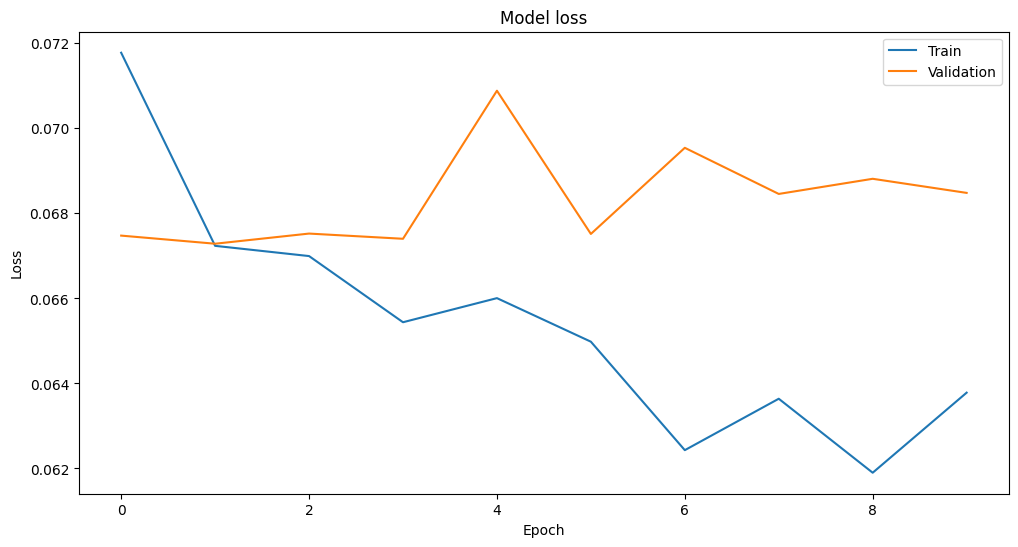

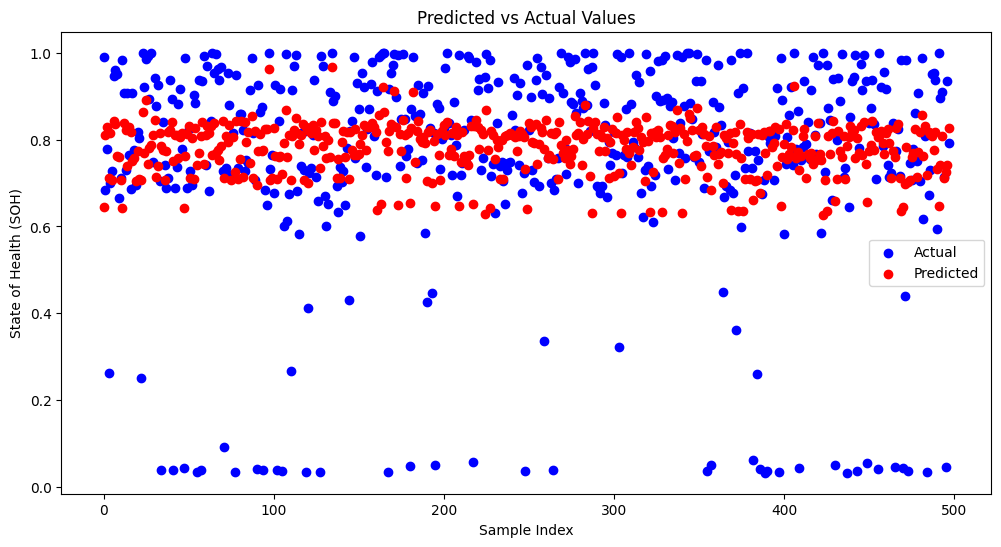

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Function to calculate and print regression metrics
def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R-squared (R²): {r2}')

# Print metrics for training set
print("Training Metrics:")
print_regression_metrics(y_train, y_pred_train)

# Print metrics for test set
print("Testing Metrics:")
print_regression_metrics(y_test, y_pred_test)

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot predictions vs actual values for test set
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(y_test)), y_pred_test, color='red', label='Predicted')
plt.title('Predicted vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('State of Health (SOH)')
plt.legend()
plt.show()


In [ ]:
###Lets see using the attenstion mechanism and bi lstm only
#Data preparation for Bi-LSTM with Attention

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Normalize the discharge data
def normalize_discharge(discharge):
    scaler = MinMaxScaler()
    return scaler.fit_transform(discharge)

# Apply normalization to the discharge column
TrainBatteryDF['discharge'] = TrainBatteryDF['discharge'].apply(lambda x: normalize_discharge(np.array(x)))

# Calculate the mean of the discharge sequences
discharge_means = TrainBatteryDF['discharge'].apply(np.mean)

# Define a custom padding function
def pad_with_mean(sequences, maxlen, mean_values):
    padded_sequences = []
    for seq, mean_val in zip(sequences, mean_values):
        # Calculate the number of padding elements needed
        num_padding = maxlen - len(seq)
        # Create the padding array filled with the mean value
        padding = np.full((num_padding, seq.shape[1]), mean_val, dtype='float16')
        # Concatenate the sequence and the padding
        padded_seq = np.concatenate([seq, padding], axis=0)
        padded_sequences.append(padded_seq)
    return padded_sequences

# Determine the maximum length of the sequences
max_length = max(TrainBatteryDF['discharge'].apply(len))

# Apply custom padding with mean values
TrainBatteryDF['discharge'] = pad_with_mean(TrainBatteryDF['discharge'], maxlen=max_length, mean_values=discharge_means)

# Convert the padded sequences back to a list if necessary
TrainBatteryDF['discharge'] = TrainBatteryDF['discharge'].apply(lambda x: x.tolist())

# Split into train and test sets
X = np.array(TrainBatteryDF['discharge'].tolist())
y = np.array(TrainBatteryDF['state_of_health'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape for LSTM input (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))


<ipython-input-21-eff0525b8a1b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TrainBatteryDF['discharge'] = TrainBatteryDF['discharge'].apply(lambda x: normalize_discharge(np.array(x)))
<ipython-input-21-eff0525b8a1b>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TrainBatteryDF['discharge'] = pad_with_mean(TrainBatteryDF['discharge'], maxlen=max_length, mean_values=discharge_means)
<ipython-input-21-eff0525b8a1b>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [ ]:
#Hybrid Cuckoo Search for Hyperparameter Optimization

import numpy as np

# Levy Flight function
def levy_flight(Lambda):
    sigma = (np.math.gamma(1 + Lambda) * np.sin(np.pi * Lambda / 2) /
             (np.math.gamma((1 + Lambda) / 2) * Lambda * 2 ** ((Lambda - 1) / 2)) ** (1 / Lambda))
    u = np.random.randn() * sigma
    v = np.random.randn()
    step = u / abs(v) ** (1 / Lambda)
    return step

# Objective function to minimize (MSE of the Bi-LSTM model)
def objective_function(params, X_train, y_train, X_val, y_val):
    lr, batch_size, lstm_units = params
    batch_size = int(batch_size)
    lstm_units = int(lstm_units)

    model = build_bilstm_attention_model(X_train.shape[1:], lstm_units, lr)
    history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0)
    mse = history.history['val_loss'][-1]
    return mse

# Cuckoo Search algorithm
def cuckoo_search(n, X_train, y_train, X_val, y_val):
    # Parameters of Cuckoo Search
    n_iterations = 100
    pa = 0.25  # Discovery rate of alien eggs/solutions
    Lambda = 1.5  # Levy flight parameter

    # Initialize nests randomly
    nests = np.random.rand(n, 3)
    nests[:, 0] = nests[:, 0] * 0.01  # Learning rate
    nests[:, 1] = nests[:, 1] * 32 + 32  # Batch size (32 to 64)
    nests[:, 2] = nests[:, 2] * 100 + 50  # LSTM units (50 to 150)

    fitness = np.zeros(n)
    for i in range(n):
        fitness[i] = objective_function(nests[i], X_train, y_train, X_val, y_val)

    best_nest = nests[np.argmin(fitness)]
    best_fitness = np.min(fitness)

    for t in range(n_iterations):
        for i in range(n):
            new_nest = nests[i] + levy_flight(Lambda) * (nests[i] - best_nest)
            new_fitness = objective_function(new_nest, X_train, y_train, X_val, y_val)
            if new_fitness < fitness[i]:
                nests[i] = new_nest
                fitness[i] = new_fitness
                if new_fitness < best_fitness:
                    best_nest = new_nest
                    best_fitness = new_fitness

        for i in range(n):
            if np.random.rand() < pa:
                nests[i] = np.random.rand(3)
                nests[i, 0] = nests[i, 0] * 0.01
                nests[i, 1] = nests[i, 1] * 32 + 32
                nests[i, 2] = nests[i, 2] * 100 + 50
                fitness[i] = objective_function(nests[i], X_train, y_train, X_val, y_val)
                if fitness[i] < best_fitness:
                    best_nest = nests[i]
                    best_fitness = fitness[i]

    return best_nest, best_fitness


In [ ]:
#Bi-LSTM Model with Attention Mechanism

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Layer
import tensorflow.keras.backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], input_shape[-1]), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[-1],), initializer='random_normal', trainable=True)
        self.u = self.add_weight(name='attention_u', shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        uit = K.tanh(K.dot(x, self.W) + self.b)
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.softmax(ait)
        ait = K.expand_dims(ait)
        weighted_input = x * ait
        return K.sum(weighted_input, axis=1)

def build_bilstm_attention_model(input_shape, lstm_units, learning_rate):
    inputs = Input(shape=input_shape)
    bilstm = Bidirectional(LSTM(lstm_units, return_sequences=True))(inputs)
    bilstm = Bidirectional(LSTM(lstm_units, return_sequences=True))(bilstm)
    attention = AttentionLayer()(bilstm)
    output = Dense(1)(attention)
    model = Model(inputs, output)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Hyperparameters
lstm_units = 64
learning_rate = 0.001

# Build the model
model = build_bilstm_attention_model(X_train.shape[1:], lstm_units, learning_rate)

# Train the model
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2)


Epoch 1/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 0.1576 - val_loss: 0.0617
Epoch 2/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 0.0400 - val_loss: 0.0271
Epoch 3/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 0.0169 - val_loss: 0.0135
Epoch 4/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - loss: 0.0115 - val_loss: 0.0115
Epoch 5/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - loss: 0.0100 - val_loss: 0.0130
Epoch 6/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 0.0106 - val_loss: 0.0106
Epoch 7/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 0.0096 - val_loss: 0.0111
Epoch 8/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 0.0094 - val_loss: 0.0091
Epoch 9/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - loss: 0.0085 - val_loss: 0.0087
Epoch 11/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - loss: 0.0085 - val_loss: 0.0141
Epoch 12/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 0.0094 - val_lo

In [ ]:
# Evaluate the model
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Function to calculate and print regression metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R^2: {r2}")

# Print metrics for train and test sets
print("Training set metrics:")
print_regression_metrics(y_train, y_pred_train)

print("Test set metrics:")
print_regression_metrics(y_test, y_pred_test)


63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 361ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step
Training set metrics:
MSE: 0.003096898813194129
RMSE: 0.0556497871801333
MAE: 0.03732876503805237
R^2: 0.9444712458677129
Test set metrics:
MSE: 0.0033135294995512805
RMSE: 0.05756326519188501
MAE: 0.03877506825211798
R^2: 0.9441207358949042


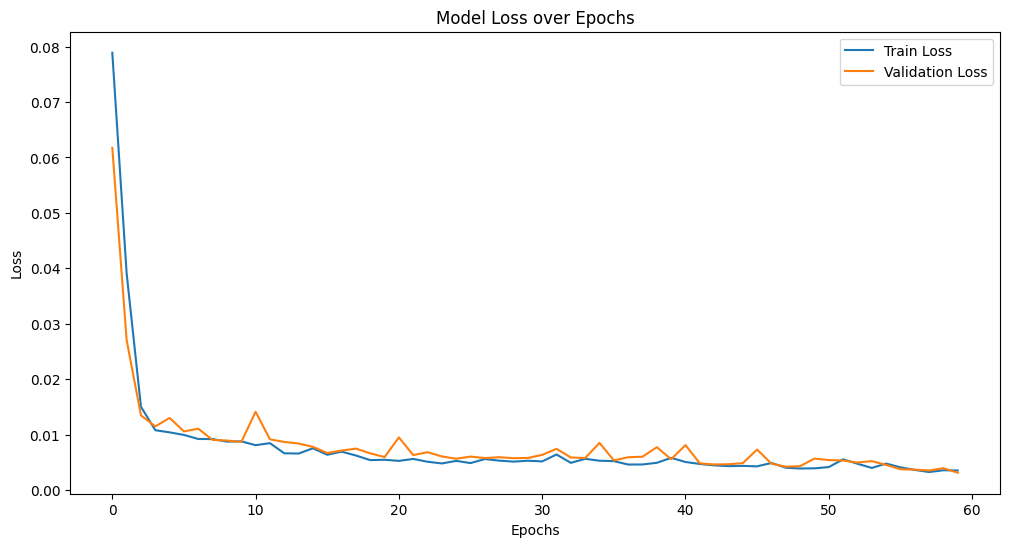

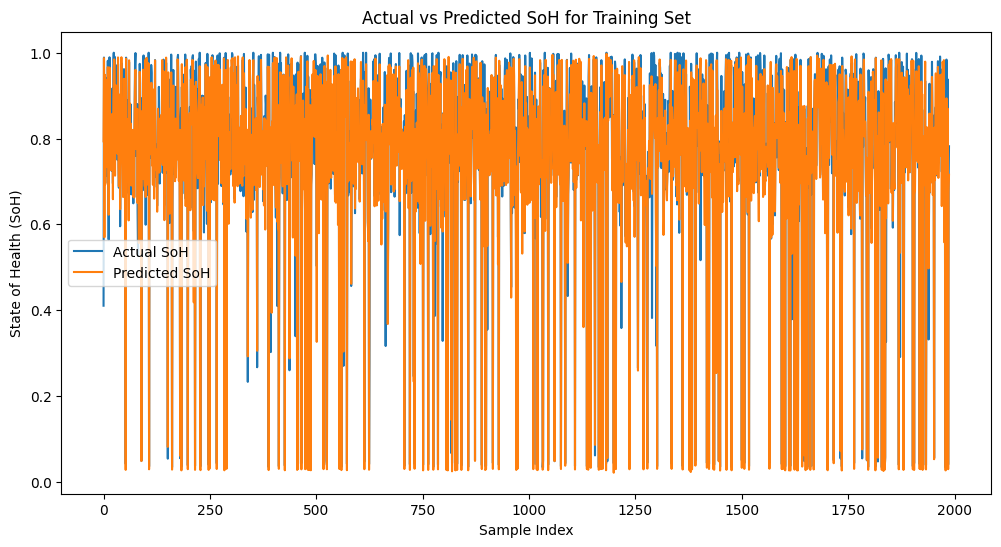

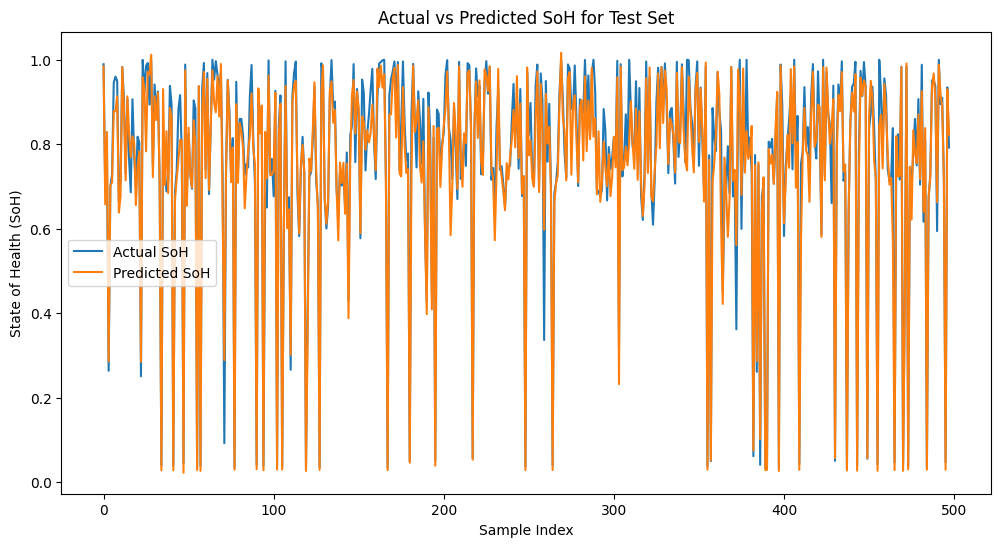

ValueError: x and y must be the same size

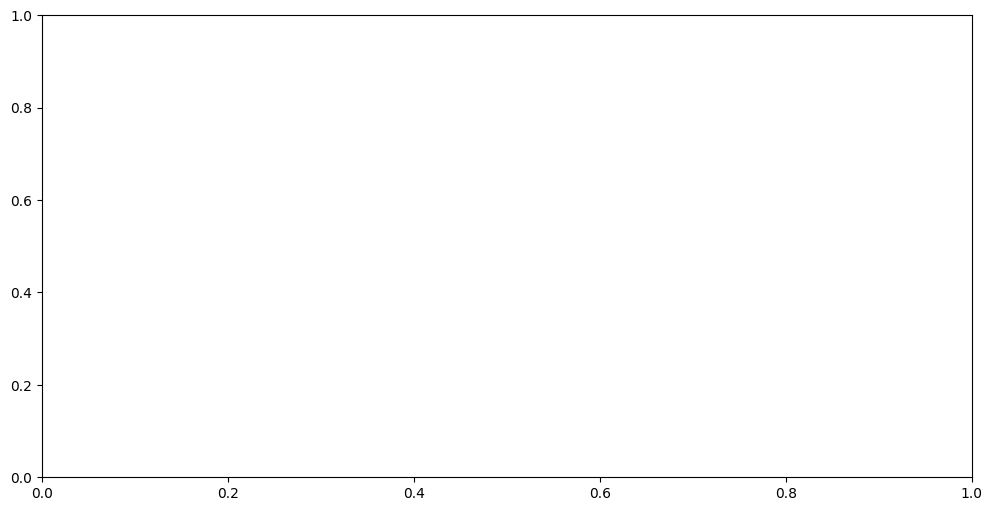

In [ ]:
#PLOTTING THE PLOTS

import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot actual vs predicted SoH for training set
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Actual SoH')
plt.plot(y_pred_train, label='Predicted SoH')
plt.title('Actual vs Predicted SoH for Training Set')
plt.xlabel('Sample Index')
plt.ylabel('State of Health (SoH)')
plt.legend()
plt.show()

# Plot actual vs predicted SoH for test set
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual SoH')
plt.plot(y_pred_test, label='Predicted SoH')
plt.title('Actual vs Predicted SoH for Test Set')
plt.xlabel('Sample Index')
plt.ylabel('State of Health (SoH)')
plt.legend()
plt.show()

# Residuals plot for test set
residuals = y_test - y_pred_test
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test)), residuals, color='blue', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals Plot for Test Set')
plt.xlabel('Sample Index')
plt.ylabel('Residuals')
plt.legend()
plt.show()


In [ ]:
# Save the entire model
model.save('bilstm_attention_model.h5')

# Download the model file
from google.colab import files
files.download('bilstm_attention_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>